Arquitectura de la red:

1280 capa de entrada (tamaño input)-> 1024 oculta1->512 oculta2->128 oculta3->16 oculta4->capa 1 neurona sigmoide(Salida)

Capas ocultas: activacion Relu, optimizador ADAM(lr=0.00001). Regularización con dropout(0.3) depues de cada capa.

Basado en la bibliografía: https://pmc.ncbi.nlm.nih.gov/articles/PMC10704805/#:~:text=of%20protein%20pair%20were%20extracted,corresponded%20to%20a%20positive%20interaction

In [ ]:
%reset -f


In [ ]:
import tensorflow.keras as ks
import numpy as np
import tensorflow as tf
from keras.initializers import RandomNormal, HeNormal
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras import backend as K

SEED = 42 # el valor que tú quieras

tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
oculta1=ks.layers.Dense(units=1024,activation='relu',input_shape=[1280])
oculta2=ks.layers.Dense(units=512,activation='relu')
oculta3=ks.layers.Dense(units=128,activation='relu')
oculta4=ks.layers.Dense(units=16,activation='relu')
salida=ks.layers.Dense(units=1,activation='sigmoid')
dropout=ks.layers.Dropout(0.4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def build_model(norm_layer):
    model = ks.Sequential([
    ks.layers.Dense(units=1024,activation='relu',input_shape=[1280]),
    ks.layers.Dropout(0.4),
    ks.layers.Dense(512, activation='relu'),
    ks.layers.Dropout(0.4),
    ks.layers.Dense(128, activation='relu'),
    ks.layers.Dropout(0.4),
    ks.layers.Dense(units=16,activation='relu'),
    ks.layers.Dense(1, activation='sigmoid')
])

    model.compile(optimizer=ks.optimizers.Adam(0.00001),
                  loss=ks.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

Como hemos usado una salida sigomide hay que ajustar nuestros datos para que X=vector de 1 y 0. 1=inmunogenico 0=no inmunogenico. Vamos a cargarlos directamente desde los archivos numpy.

In [ ]:
import numpy as np

# === Cargar test
test_data = np.load("/content/drive/MyDrive/TFM/MIERCOLES14/DATASET/test.npz", allow_pickle=True)
X_test = test_data["X"]
y_test = test_data["y"]
ids_test= test_data["ids"]

# === Cargar folds
folds = {}
for i in range(1, 6):
    data = np.load(f"/content/drive/MyDrive/TFM/MIERCOLES14/DATASET/train_fold{i}.npz", allow_pickle=True)
    globals()[f"X_fold{i}"] = data["X"]
    globals()[f"y_fold{i}"] = data["y"]



In [ ]:
results = []

for i in range(1, 6):
    print(f"\n--- Fold {i} ---")

    # Fold i será el de validación
    X_val = globals()[f"X_fold{i}"]
    y_val = globals()[f"y_fold{i}"]

    # Los demás serán el entrenamiento
    X_tr = np.concatenate([globals()[f"X_fold{j}"] for j in range(1, 6) if j != i])
    y_tr = np.concatenate([globals()[f"y_fold{j}"] for j in range(1, 6) if j != i])

    # Calcular pesos de clase para este fold
    classes = np.unique(y_tr)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
    class_weight = dict(zip(classes, weights))
    normalizer = ks.layers.Normalization()
    normalizer.adapt(X_tr)
    def build_model(norm_layer):
          model = ks.Sequential([
          norm_layer,
          ks.layers.Dense(units=1024,activation='relu',input_shape=[1280]),
          ks.layers.Dropout(0.4),
          ks.layers.Dense(512, activation='relu'),
          ks.layers.Dropout(0.4),
          ks.layers.Dense(128, activation='relu'),
          ks.layers.Dropout(0.4),
          ks.layers.Dense(units=16,activation='relu'),
          ks.layers.Dense(1, activation='sigmoid')])

          model.compile(optimizer=ks.optimizers.Adam(0.00001),
                        loss=ks.losses.BinaryCrossentropy(from_logits=False),
                        metrics=['accuracy'])
          return model
    # Crear modelo nuevo
    model = build_model(normalizer)

    # Entrenamiento
    model.fit(X_tr, y_tr,
              validation_data=(X_val, y_val),
              epochs=500,
              batch_size=30,
              class_weight=class_weight,
              callbacks=[ks.callbacks.EarlyStopping(patience=30, restore_best_weights=True)],
              verbose=0)

    # Evaluación
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
    report = classification_report(y_val, y_val_pred, output_dict=False)
    print(report)
    report = classification_report(y_val, y_val_pred, output_dict=True)
    results.append(report)





--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       252
           1       0.65      0.64      0.64       164

    accuracy                           0.72       416
   macro avg       0.71      0.71      0.71       416
weighted avg       0.72      0.72      0.72       416


--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       272
           1       0.75      0.77      0.76       184

    accuracy                           0.80       456
   macro avg       0.79      0.80      0.80       456
weighted avg       0.80      0.80      0.80       456


--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       238
           1       0.76      0.72      0.74       150

    accuracy                           0.80       388
   macro avg       0.79      0.79      0.79       388
weighted avg       0.80      0.80      0.80       388


--- Fold 4 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       294
           1       0.72      0.76      0.74       207

    accuracy                           0.78       501
   macro avg       0.78      0.78      0.78       501
weighted avg       0.78      0.78      0.78       501


--- Fold 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       300
           1       0.78      0.69      0.73       213

    accuracy                           0.79       513
   macro avg       0.79      0.77      0.78       513
weighted avg       0.79      0.79      0.79       513



In [ ]:
def extraer_metricas(report_dict):
    return {
        "accuracy": report_dict["accuracy"],
        "precision": report_dict["weighted avg"]["precision"],
        "recall": report_dict["weighted avg"]["recall"],
        "f1-score": report_dict["weighted avg"]["f1-score"]
    }

# Extraer métricas de todos los folds
metricas_folds = [extraer_metricas(r) for r in results]

# Calcular promedio y desviación estándar
import numpy as np
keys = metricas_folds[0].keys()
promedios = {k: np.mean([m[k] for m in metricas_folds]) for k in keys}
desviaciones = {k: np.std([m[k] for m in metricas_folds]) for k in keys}

# Imprimir
print("\n=== RESULTADOS VALIDACIÓN CRUZADA ===")
for k in keys:
    print(f"{k.capitalize()}: {promedios[k]:.4f} ± {desviaciones[k]:.4f}")



=== RESULTADOS VALIDACIÓN CRUZADA ===
Accuracy: 0.7796 ± 0.0304
Precision: 0.7797 ± 0.0306
Recall: 0.7796 ± 0.0304
F1-score: 0.7791 ± 0.0303



--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       252
           1       0.60      0.68      0.64       164

    accuracy                           0.69       416
   macro avg       0.68      0.69      0.68       416
weighted avg       0.70      0.69      0.70       416


--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       272
           1       0.73      0.74      0.73       184

    accuracy                           0.78       456
   macro avg       0.77      0.78      0.78       456
weighted avg       0.78      0.78      0.78       456


--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       238
           1       0.78      0.68      0.73       150

    accuracy                           0.80       388
   macro avg       0.80      0.78      0.79       388
weighted avg       0.80      0.80      0.80       388


--- Fold 4 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       294
           1       0.79      0.67      0.72       207

    accuracy                           0.79       501
   macro avg       0.79      0.77      0.78       501
weighted avg       0.79      0.79      0.79       501


--- Fold 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       300
           1       0.78      0.64      0.70       213

    accuracy                           0.78       513
   macro avg       0.78      0.76      0.76       513
weighted avg       0.78      0.78      0.77       513


=== Métricas por fold (accuracy, precision, recall, f1-score) ===


,accuracy,precision,recall,f1-score
Fold,,,,
Fold 1,0.6923,0.7025,0.6923,0.6951
Fold 2,0.7829,0.7835,0.7829,0.7832
Fold 3,0.8041,0.8026,0.8041,0.8011
Fold 4,0.7884,0.7884,0.7884,0.7850
Fold 5,0.7758,0.7761,0.7758,0.7717



=== Métricas promedio ± desviación estándar ===


,accuracy,precision,recall,f1-score
Fold,,,,
Fold 1,0.692308,0.702472,0.692308,0.695105
Fold 2,0.782895,0.783515,0.782895,0.783171
Fold 3,0.804124,0.802611,0.804124,0.801077
Fold 4,0.788423,0.788438,0.788423,0.785021
Fold 5,0.775828,0.776112,0.775828,0.771678
Promedio ± STD,0.7687 ± 0.0440,0.7706 ± 0.0393,0.7687 ± 0.0440,0.7672 ± 0.0416


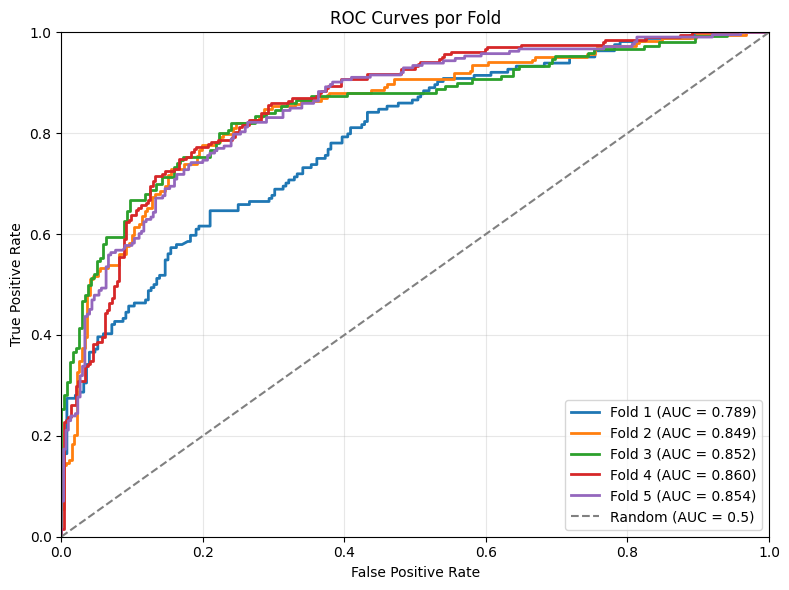

from matplotlib import pyplot as plt
import seaborn as sns
df_metricas_con_prom.groupby('accuracy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_metricas_con_prom.groupby('precision').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_metricas_con_prom.groupby('recall').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_metricas_con_prom.groupby('f1-score').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

TypeError: '<' not supported between instances of 'str' and 'float'

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['precision'].value_counts()
    for x_label, grp in df_metricas_con_prom.groupby('accuracy')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('accuracy')
_ = plt.ylabel('precision')

TypeError: '<' not supported between instances of 'str' and 'float'

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['recall'].value_counts()
    for x_label, grp in df_metricas_con_prom.groupby('precision')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('precision')
_ = plt.ylabel('recall')

TypeError: '<' not supported between instances of 'str' and 'float'

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['f1-score'].value_counts()
    for x_label, grp in df_metricas_con_prom.groupby('recall')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('recall')
_ = plt.ylabel('f1-score')

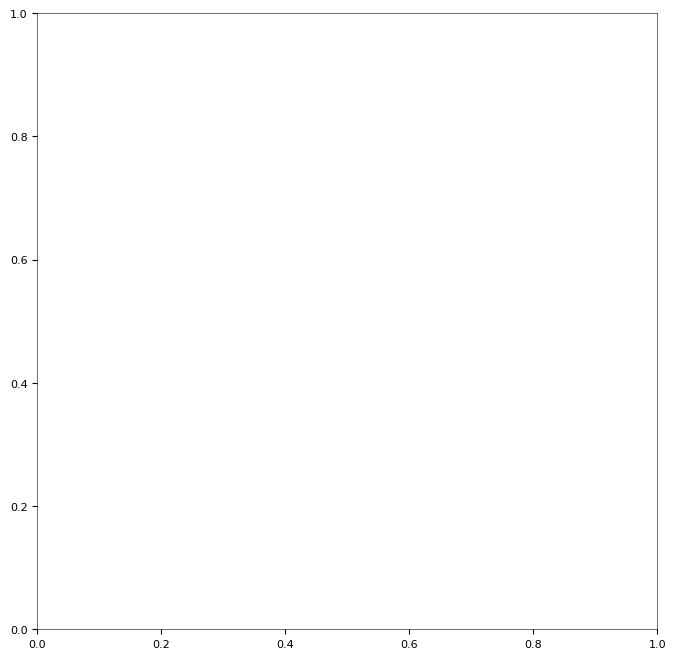

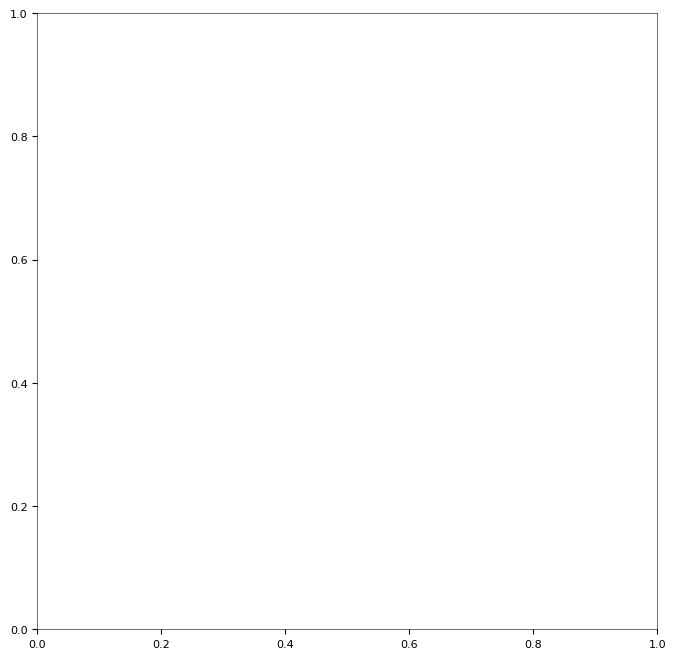

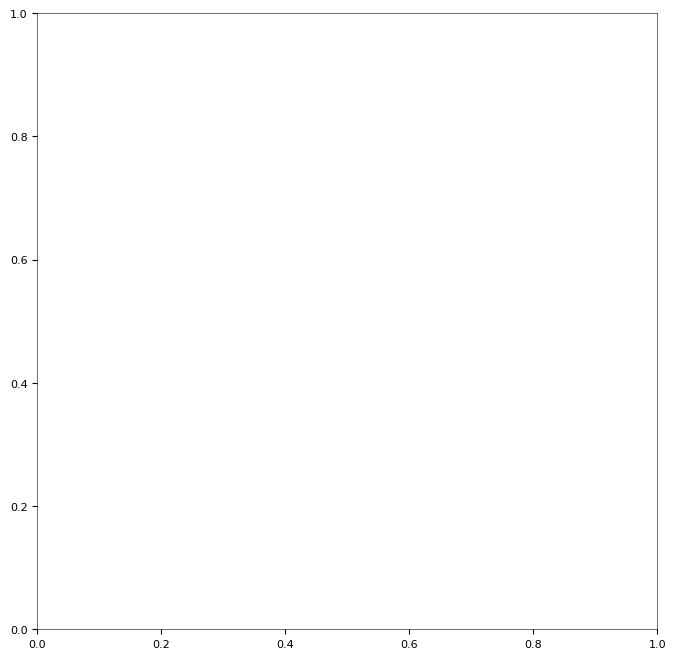

In [ ]:
import numpy as np
import tensorflow.keras as ks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc
)
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Prepara listas donde iremos guardando:
#    - 'results': cada elemento será el dict de classification_report de un fold
#    - 'y_true_folds': etiquetas verdaderas (array) de validación para cada fold
#    - 'y_score_folds': probabilidades predichas (array) de validación para cada fold
# ------------------------------------------------------------
results = []
y_true_folds  = []
y_score_folds = []

# Función auxiliar para extraer sólo las métricas que queremos
def extraer_metricas(report_dict):
    return {
        "accuracy": report_dict["accuracy"],
        "precision": report_dict["weighted avg"]["precision"],
        "recall": report_dict["weighted avg"]["recall"],
        "f1-score": report_dict["weighted avg"]["f1-score"]
    }

# ------------------------------------------------------------
# 2) Bucle de validación cruzada 5-fold
# ------------------------------------------------------------
for i in range(1, 6):
    print(f"\n--- Fold {i} ---")

    # ===== 2.1 Separa X_val, y_val (fold i) =====
    X_val = globals()[f"X_fold{i}"]
    y_val = globals()[f"y_fold{i}"]

    # ===== 2.2 Construye X_tr, y_tr como concatenación de los otros 4 folds =====
    X_tr = np.concatenate([globals()[f"X_fold{j}"] for j in range(1, 6) if j != i])
    y_tr = np.concatenate([globals()[f"y_fold{j}"] for j in range(1, 6) if j != i])

    # ===== 2.3 Calcula pesos de clase para training del fold i =====
    clases = np.unique(y_tr)
    pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_tr)
    class_weight = dict(zip(clases, pesos))

    # ===== 2.4 Normalización =====
    normalizer = ks.layers.Normalization()
    normalizer.adapt(X_tr)

    # ===== 2.5 Función para construir el modelo =====
    def build_model(norm_layer):
        model = ks.Sequential([
            norm_layer,
            ks.layers.Dense(units=1024, activation='relu', input_shape=[X_tr.shape[1]]),
            ks.layers.Dropout(0.4),
            ks.layers.Dense(512, activation='relu'),
            ks.layers.Dropout(0.4),
            ks.layers.Dense(128, activation='relu'),
            ks.layers.Dropout(0.4),
            ks.layers.Dense(units=16, activation='relu'),
            ks.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=ks.optimizers.Adam(1e-5),
            loss=ks.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy']
        )
        return model

    # ===== 2.6 Crea y entrena el modelo =====
    model = build_model(normalizer)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=500,
        batch_size=30,
        class_weight=class_weight,
        callbacks=[
            ks.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
        ],
        verbose=0
    )

    # ===== 2.7 Obtén probabilidades y predicciones sobre el fold de validación =====
    y_val_prob = model.predict(X_val).ravel()          # Probabilidad de clase positiva (shape: (n_val,))
    y_val_pred = (y_val_prob > 0.5).astype(int)        # Etiquetas binarias con umbral 0.5

    #  Almacena las etiquetas y probabilidades para dibujar la ROC después
    y_true_folds.append(y_val)
    y_score_folds.append(y_val_prob)

    # ===== 2.8 Clasification report para el fold i =====
    report_dict = classification_report(
        y_val, y_val_pred,
        output_dict=True, zero_division=0
    )
    # Lo imprimimos (opcional)
    print(classification_report(y_val, y_val_pred, zero_division=0))
    # Lo guardamos en la lista results
    results.append(report_dict)

# ------------------------------------------------------------
# 3) Tras terminar todos los folds, extraemos las métricas por fold
# ------------------------------------------------------------
metricas_folds = [extraer_metricas(rep) for rep in results]

# 3.1 Construimos un DataFrame con las métricas (accuracy, precision, recall, f1-score)
df_metricas = pd.DataFrame(
    metricas_folds,
    index=[f"Fold {i+1}" for i in range(len(metricas_folds))]
)
df_metricas.index.name = "Fold"
# Aseguramos el orden de columnas
df_metricas = df_metricas[["accuracy", "precision", "recall", "f1-score"]]

# 3.2 Calculamos promedio y desviación estándar para cada métrica
promedios = df_metricas.mean()
desviaciones = df_metricas.std()
fila_prom_std = {
    col: f"{promedios[col]:.4f} ± {desviaciones[col]:.4f}"
    for col in df_metricas.columns
}

# 3.3 Generamos un DataFrame donde la última fila es “Promedio ± STD”
df_metricas_con_prom = df_metricas.copy()
df_metricas_con_prom.loc["Promedio ± STD"] = pd.Series(fila_prom_std)

# 3.4 Mostramos las tablas
print("\n=== Métricas por fold (accuracy, precision, recall, f1-score) ===")
display(df_metricas.style.format("{:.4f}"))

print("\n=== Métricas promedio ± desviación estándar ===")
display(df_metricas_con_prom)

# ------------------------------------------------------------
# 4) Dibujar las curvas ROC de cada fold
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
for i, (y_true, y_score) in enumerate(zip(y_true_folds, y_score_folds)):
    # Calculamos FPR, TPR y AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # Trazamos la curva para el fold i
    plt.plot(
        fpr, tpr,
        lw=2,
        label=f'Fold {i+1} (AUC = {roc_auc:.3f})'
    )

# Diagonal de referencia: clasificador aleatorio
plt.plot(
    [0, 1], [0, 1],
    linestyle='--',
    color='gray',
    label='Random (AUC = 0.5)'
)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves por Fold")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# === Combinar todos los folds para entrenamiento final
X_all = np.concatenate([globals()[f"X_fold{i}"] for i in range(1, 6)])
y_all = np.concatenate([globals()[f"y_fold{i}"] for i in range(1, 6)])
import gc
ks.backend.clear_session()
gc.collect()

normalizer = ks.layers.Normalization()
normalizer.adapt(X_all)
# === Calcular pesos de clase
classes = np.unique(y_all)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_all)
class_weight = dict(zip(classes, weights))
def build_model():
          model = ks.Sequential([
          ks.layers.Dense(units=1024,activation='relu',input_shape=[1280]),
          ks.layers.Dropout(0.4),
          ks.layers.Dense(512, activation='relu'),
          ks.layers.Dropout(0.4),
          ks.layers.Dense(128, activation='relu'),
          ks.layers.Dropout(0.4),
          ks.layers.Dense(units=16,activation='relu'),
          ks.layers.Dense(1, activation='sigmoid')])

          model.compile(optimizer=ks.optimizers.Adam(0.00001),
                        loss=ks.losses.BinaryCrossentropy(from_logits=False),
                        metrics=['accuracy'])
          return model
# === Crear y entrenar el modelo final
final_model = build_model()

final_model.fit(X_all, y_all,
                epochs=200,
                batch_size=30,
                class_weight=class_weight,
                callbacks=[ks.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
                )

# === Evaluación en el conjunto de test
y_test_pred = (final_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report
print("\n=== EVALUACIÓN FINAL EN TEST ===")
print(classification_report(y_test, y_test_pred))


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4876 - loss: 0.6946
Epoch 2/200
61/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5134 - loss: 0.6961

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5134 - loss: 0.6962
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5195 - loss: 0.6934
Epoch 4/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5149 - loss: 0.6905
Epoch 5/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5432 - loss: 0.6876
Epoch 6/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5620 - loss: 0.6849
Epoch 7/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5616 - loss: 0.6846
Epoch 8/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5977 - loss: 0.6755
Epoch 9/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5935 - loss: 0.6789
Epoch 10/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6168 - loss: 0.6731
Epoch 11/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5799 - loss: 0.6782
Epoch 12/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6155 - loss: 0.6711
Epoch 13/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5992 - l

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

=== EVALUACIÓN FINAL EN TEST ===
              precision    recall  f1-score   support

           0       0.84      0.54      0.66        68
           1       0.67      0.90      0.77        70

    accuracy                           0.72       138
   macro avg       0.76      0.72      0.71       138
weighted avg       0.75      0.72      0.72       138



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
138
Recall (sobre positivos): 0.9


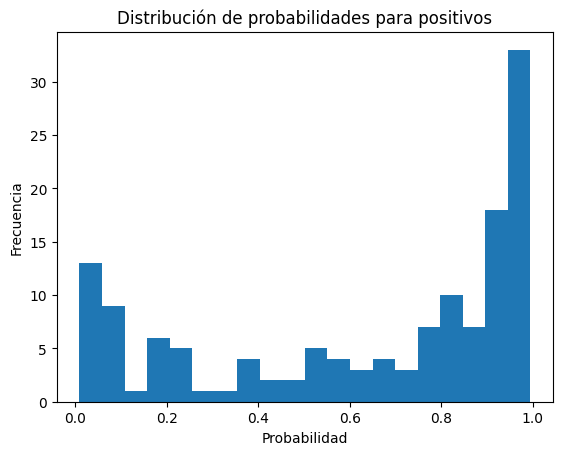

=== Métricas PU ===
ROC-AUC:     0.824
PR-AUC:      0.835
PU-Precision: 0.670
PU-Recall:    0.900


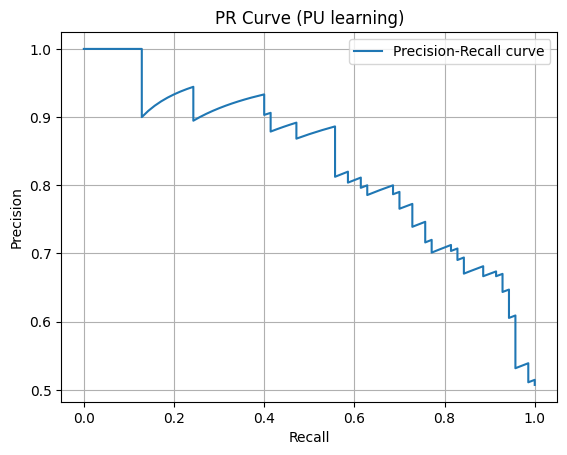

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt

X_pos=X_test
y_pos =y_test
# === 4. Evaluación básica
probs= final_model.predict(X_pos)
y_pred   = (probs > 0.5).astype(int)
print(len(y_pred))
print("Recall (sobre positivos):", recall_score(y_pos, y_pred))
plt.hist(probs, bins=20)
plt.title("Distribución de probabilidades para positivos")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.show()
# === Métricas para PU learning ===
roc_auc = roc_auc_score(y_pos, probs)
pr_auc = average_precision_score(y_pos, probs)
pu_precision = precision_score(y_pos, y_pred, zero_division=0)
pu_recall = recall_score(y_pos, y_pred)

print("=== Métricas PU ===")
print(f"ROC-AUC:     {roc_auc:.3f}")
print(f"PR-AUC:      {pr_auc:.3f}")
print(f"PU-Precision: {pu_precision:.3f}")
print(f"PU-Recall:    {pu_recall:.3f}")

# === Curva Precision-Recall ===
precisions, recalls, _ = precision_recall_curve(y_pos, probs)

plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve (PU learning)")
plt.legend()
plt.grid()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: 0.884
Recall: 0.974
F1-score: 0.927


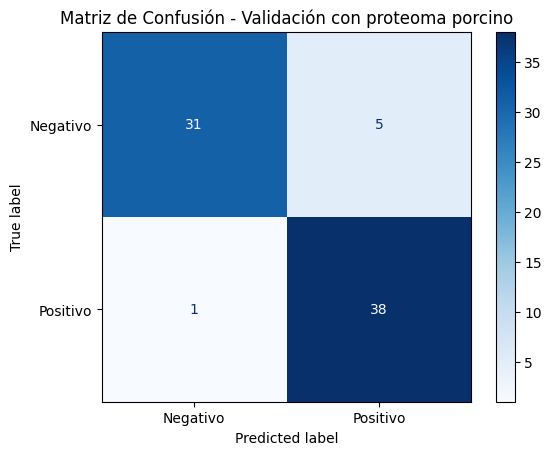

Umbral para FPR≤1%: 0.8906


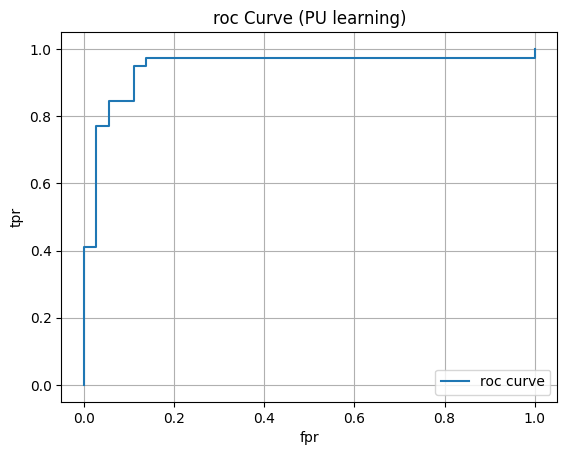

In [ ]:
# === Obtener predicciones
probs = final_model.predict(X_test)
y_pred = (probs > 0.5).astype(int).flatten()

# === Filtrar por IDs que contienen "epi"
ids_test = test_data["ids"]
mask_epi = np.array(["epi" in s for s in ids_test])

# Aplicar el filtro
y_true = y_test[mask_epi]
y_pred = y_pred[mask_epi]
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Positivo"])
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Validación con proteoma porcino")
plt.show()

# === Curva Precision-Recall ===
precisions, recalls, _ = precision_recall_curve(y_pos, probs)
from sklearn.metrics import roc_curve

# y_true: etiquetas verdaderas (0/1), y_proba: prob. modelo
fpr, tpr, umbrales = roc_curve(y_true, probs[mask_epi])

# Busca el mayor umbral que mantenga FPR ≤ 0.01
idx_valid = np.where(fpr <= 0.25)[0]
best_idx = idx_valid[np.argmax(tpr[idx_valid])]  # maximiza TPR sujeto a FPR≤0.01
best_threshold = umbrales[best_idx]

print(f"Umbral para FPR≤1%: {best_threshold:.4f}")

plt.plot(fpr, tpr, label='roc curve')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("roc Curve (PU learning)")
plt.legend()
plt.grid()
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precision: 0.066
Recall: 0.452
F1-score: 0.115


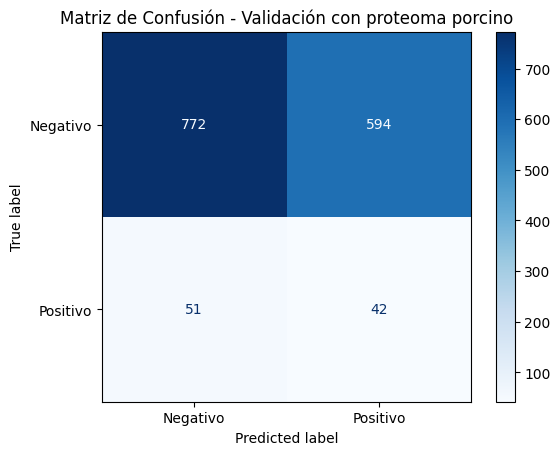

In [ ]:
X_true=np.load("/content/drive/MyDrive/TFM/VALIDACION/sus_scrofa_antigens.npz")["X"]
y_true =np.load("/content/drive/MyDrive/TFM/VALIDACION/sus_scrofa_antigens.npz")["y"]



# === 4. Evaluación básica
probs= final_model.predict(X_true)
y_pred   = (probs > 0.5).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Positivo"])
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Validación con proteoma porcino")
plt.show()

In [ ]:
#final_model.save('immupig_epoch500.keras')
from tensorflow.keras.models import load_model

final_model = load_model('immupig_epoch500.keras')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


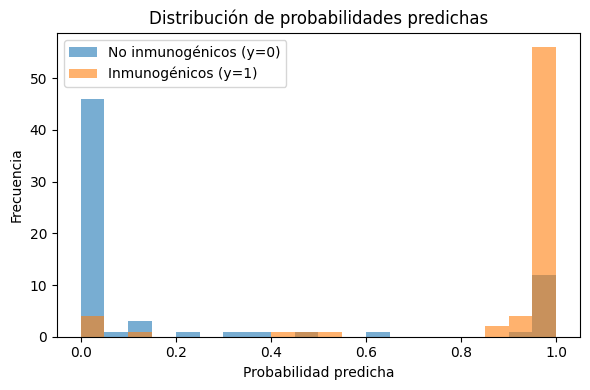

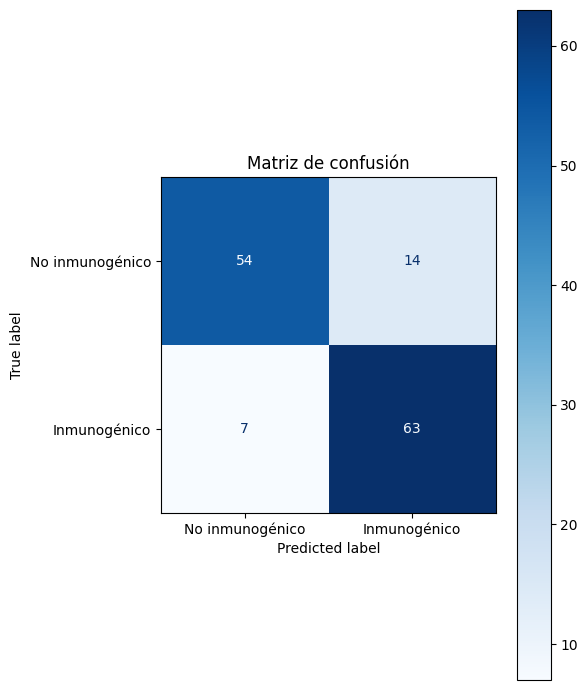

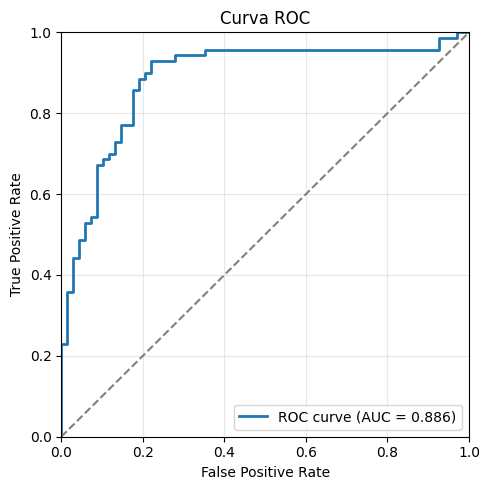

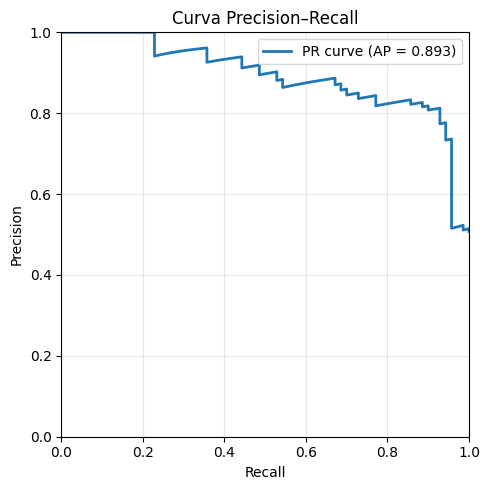

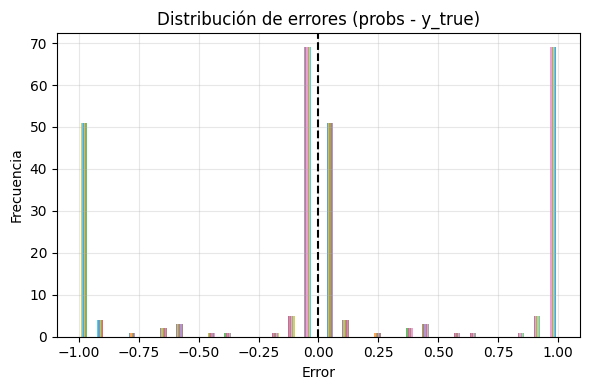

=== Métricas finales ===
Accuracy:   0.501
Precision:  0.818
Recall:     0.900
F1-score:   0.857
AUC-ROC:    0.886
AUC-PR:     0.893


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# === 0. Previo: obtener probabilidades y predicciones ===
probs = final_model.predict(X_test)             # Puntuaciones/probabilidades entre 0 y 1
y_pred = (probs >= 0.5).astype(int)              # Umbral 0.5 para convertir en etiquetas 0/1
y_true = y_test

# 1. Histogramas de probabilidades (positivos vs. negativos por separado)
plt.figure(figsize=(6,4))
plt.hist(probs[y_true==0], bins=20, alpha=0.6, label='No inmunogénicos (y=0)')
plt.hist(probs[y_true==1], bins=20, alpha=0.6, label='Inmunogénicos (y=1)')
plt.title("Distribución de probabilidades predichas")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Matriz de confusión
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No inmunogénico','Inmunogénico'])
plt.figure(figsize=(6,7))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()

# 3. Curva ROC y AUC
fpr, tpr, thresholds_roc = roc_curve(y_true, probs)
auc_roc = roc_auc_score(y_true, probs)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc_roc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Curva Precision–Recall y AUC-PR
precision, recall, thresholds_pr = precision_recall_curve(y_true, probs)
auc_pr = average_precision_score(y_true, probs)

plt.figure(figsize=(5,5))
plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {auc_pr:.3f})')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# 6. (Opcional) Distribución de “errores” (residuos) para clasificación
#    Aquí definimos el “error” como (probabilidad_predicha - etiqueta_real).
errors = probs - y_true
plt.figure(figsize=(6,4))
plt.hist(errors, bins=30, alpha=0.7)
plt.axvline(0, color='k', linestyle='--')
plt.title("Distribución de errores (probs - y_true)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# === Imprimir métricas resumidas ===
print("=== Métricas finales ===")
print(f"Accuracy:   {(y_pred == y_true).mean():.3f}")
print(f"Precision:  {precision_score(y_true, y_pred, zero_division=0):.3f}")
print(f"Recall:     {recall_score(y_true, y_pred):.3f}")
print(f"F1-score:   {f1_score(y_true, y_pred):.3f}")
print(f"AUC-ROC:    {auc_roc:.3f}")
print(f"AUC-PR:     {auc_pr:.3f}")
